In [132]:
import s3fs
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
import numpy.polynomial.polynomial as poly

In [11]:
cov_sum = pd.read_csv("s3://czbiohub-mosquito/contig_quality_concat/Mos/CoverageSummaryStatsFinal.csv")
cov_sum = cov_sum.assign(length=cov_sum.contig_id.str.split("_").apply(lambda x: int(x[3])))

In [9]:
cov_sum.head(n=10)

,contig_id,count,mean,std,min,25%,50%,75%,max,sample
0,NODE_10000_length_238_cov_0.763975,238.0,2.268908,0.625714,1.0,2.0,2.0,2.0,4.0,CMS001_001_Ra_S1
1,NODE_10001_length_238_cov_0.757764,238.0,1.260504,0.439835,1.0,1.0,1.0,2.0,2.0,CMS001_001_Ra_S1
2,NODE_10002_length_238_cov_0.751553,238.0,1.247899,0.432703,1.0,1.0,1.0,1.0,2.0,CMS001_001_Ra_S1
3,NODE_10003_length_238_cov_0.739130,238.0,1.256303,0.437511,1.0,1.0,1.0,2.0,2.0,CMS001_001_Ra_S1
4,NODE_10004_length_238_cov_0.726708,238.0,1.571429,0.495915,1.0,1.0,2.0,2.0,2.0,CMS001_001_Ra_S1
5,NODE_10005_length_238_cov_0.683230,238.0,1.890756,0.787989,1.0,1.0,2.0,3.0,3.0,CMS001_001_Ra_S1
6,NODE_10006_length_238_cov_0.677019,238.0,2.121849,0.983978,1.0,1.0,2.0,3.0,4.0,CMS001_001_Ra_S1
7,NODE_10007_length_238_cov_0.677019,238.0,1.256303,0.437511,1.0,1.0,1.0,2.0,2.0,CMS001_001_Ra_S1
8,NODE_10008_length_238_cov_0.670807,238.0,1.256303,0.437511,1.0,1.0,1.0,2.0,2.0,CMS001_001_Ra_S1
9,NODE_10009_length_238_cov_0.658385,238.0,1.260504,0.439835,1.0,1.0,1.0,2.0,2.0,CMS001_001_Ra_S1


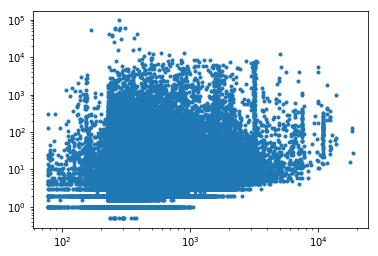

In [117]:
plt.plot(cov_sum["length"], cov_sum["50%"], '.')
plt.yscale('log')
plt.xscale('log')

Text(0,0.5,'Standard deviation of reads')

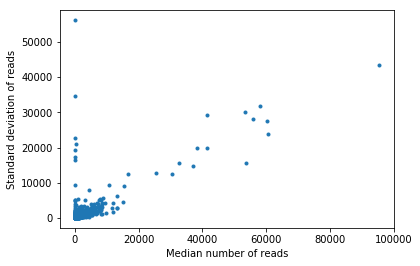

In [146]:
plt.plot(cov_sum["50%"], cov_sum["std"], '.')
plt.xlabel("Median number of reads")
plt.ylabel("Standard deviation of reads")

Text(0,0.5,'Standard deviation of reads')

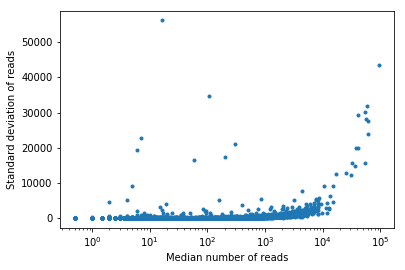

In [145]:
plt.plot(cov_sum["50%"], cov_sum["std"], '.')
plt.xscale('log')
plt.xlabel("Median number of reads")
plt.ylabel("Standard deviation of reads")

In [148]:
def curve_func(new_x, a, b):
    return (a * pow(10, b*new_x))

In [149]:
curve_fit = scipy.optimize.curve_fit(curve_func, np.log10(cov_sum["50%"]), cov_sum["std"])
curve_fit

/Users/lucy.li/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


(array([0.25557463, 1.05478988]), array([[ 6.83877950e-06, -2.49655512e-06],
        [-2.49655512e-06,  9.18793800e-07]]))

In [152]:
xdata = [float(y)/1000 for y in [x for x in range(int(np.log10(cov_sum["50%"].min()+1)), (int(np.log10(cov_sum["50%"].max()))+1)*1000)]]
ydata = [curve_func(x, curve_fit[0][0], curve_fit[0][1]) for x in xdata]



Text(0,0.5,'Standard deviation of reads')

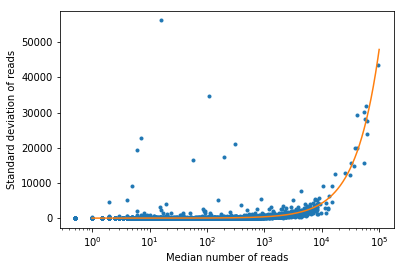

In [153]:
plt.plot(cov_sum["50%"], cov_sum["std"], '.', [pow(10, x) for x in xdata], ydata)
plt.xscale('log')
plt.xlabel("Median number of reads")
plt.ylabel("Standard deviation of reads")

In [404]:
residuals = (cov_sum["std"] - np.log10(cov_sum["50%"]+0.000001).apply(curve_func, a=curve_fit[0][0], b=curve_fit[0][1]))/np.sqrt(cov_sum["std"])
upper_residual = (residuals).quantile(q=0.999987)
outliers = [i for i, x in enumerate(residuals) if (x > upper_residual) and (cov_sum["50%"][i]>0.0)]
expected = [i for i, x in enumerate(residuals) if not ((x > upper_residual) and (cov_sum["50%"][i]>0.0))]
print(len(outliers), len(expected))




12 891240


Text(0,0.5,'Standard deviation of reads')

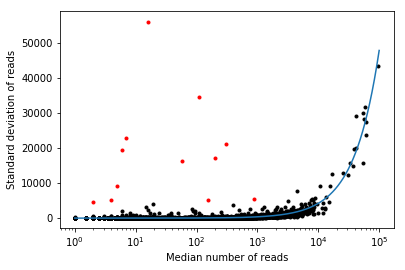

In [405]:
plt.scatter(cov_sum["50%"][expected], cov_sum["std"][expected], marker=".", c="black")
plt.scatter(cov_sum["50%"][outliers], cov_sum["std"][outliers], marker=".",  c="red")
plt.plot([pow(10, x) for x in xdata], ydata)
plt.xscale('log')
plt.xlabel("Median number of reads")
plt.ylabel("Standard deviation of reads")

In [408]:
cov_sum.iloc[outliers]

,contig_id,count,mean,std,min,25%,50%,75%,max,sample,length
35733,NODE_1077_length_835_cov_81.494723,835.0,18956.117365,34583.657364,4.0,77.0,108.0,8912.50,100750.0,CMS001_005_Ra_S3,835
52764,NODE_4870_length_455_cov_1.126984,455.0,6147.107692,9242.626845,1.0,4.0,5.0,17032.50,21986.0,CMS001_005_Ra_S3,455
99976,NODE_6193_length_457_cov_2.531579,457.0,39016.680525,56157.266309,2.0,9.0,16.0,89315.00,152920.0,CMS001_009_Ra_S13,457
135378,NODE_338_length_835_cov_369.542216,835.0,11021.372455,16430.346892,0.0,50.0,58.0,21532.00,49697.0,CMS001_014_Ra_S5,835
150497,NODE_1476_length_626_cov_43.211293,626.0,8631.239617,17225.118039,34.0,155.0,200.0,3083.75,53977.0,CMS001_016_Ra_S6,626
162186,NODE_6372_length_352_cov_0.970909,352.0,17766.656250,22832.239191,1.0,4.0,7.0,42297.50,58370.0,CMS001_016_Ra_S6,352
421168,NODE_1135_length_1291_cov_200.006590,1291.0,12380.517428,19355.465461,1.0,3.0,6.0,23984.00,59225.0,CMS002_007a_Rb_S118_L004,1291
496093,NODE_41106_length_233_cov_1.557692,233.0,3643.373391,4703.105548,1.0,2.0,2.0,9621.00,10247.0,CMS002_020a_Rb_S131_L004,233
541867,NODE_3781_length_349_cov_78.625000,349.0,18406.896848,21061.842191,0.0,253.0,306.0,43769.00,46392.0,CMS002_020e_Rb_S135_L004,349
597248,NODE_8731_length_567_cov_1.363265,567.0,1286.142857,5076.421107,1.0,3.0,4.0,8.00,21406.0,CMS002_021a_Rb_S136_L004,567


Focusing just on contigs > 1000 nt in length

In [414]:
cov_sum_long = cov_sum[cov_sum["length"]>1000]

Text(0,0.5,'Standard deviation of reads')

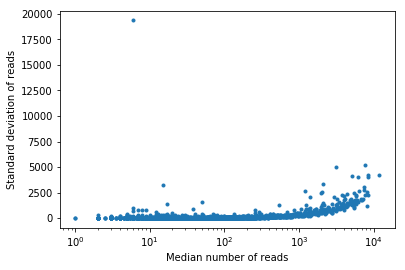

In [415]:
plt.plot(cov_sum_long["50%"], cov_sum_long["std"], '.')
plt.xscale('log')
plt.xlabel("Median number of reads")
plt.ylabel("Standard deviation of reads")

In [416]:
curve_fit_long = scipy.optimize.curve_fit(curve_func, np.log10(cov_sum_long["50%"]), cov_sum_long["std"])
curve_fit_long

(array([0.69484506, 0.92105124]), array([[ 3.20555759e-03, -5.46349164e-04],
        [-5.46349164e-04,  9.39532991e-05]]))

In [423]:
xdata_long = [float(y)/1000 for y in [x for x in range(int(np.log10(cov_sum_long["50%"].min()+1)), (int(np.log10(cov_sum_long["50%"].max())))*1000)]]
ydata_long = [curve_func(x, curve_fit_long[0][0], curve_fit_long[0][1]) for x in xdata_long]



Text(0,0.5,'Standard deviation of reads')

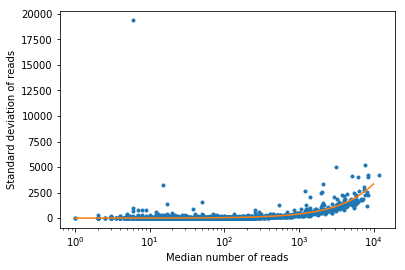

In [424]:
plt.plot(cov_sum_long["50%"], cov_sum_long["std"], '.', [pow(10, x) for x in xdata_long], ydata_long)
plt.xscale('log')
plt.xlabel("Median number of reads")
plt.ylabel("Standard deviation of reads")

In [440]:
residuals_long = (cov_sum_long["std"] - np.log10(cov_sum_long["50%"]+0.000001).apply(curve_func, a=curve_fit_long[0][0], b=curve_fit_long[0][1]))/np.sqrt(cov_sum_long["std"])
upper_residual_long = (residuals_long).quantile(q=0.999987)
outliers_long = [i for i, x in enumerate(residuals_long) if (x > upper_residual_long) and (list(cov_sum_long["50%"])[i]>0.0)]
expected_long = [i for i, x in enumerate(residuals_long) if not ((x > upper_residual_long) and (list(cov_sum_long["50%"])[i]>0.0))]
print(len(outliers_long), len(expected_long))



1 22801


Text(0,0.5,'Standard deviation of reads')

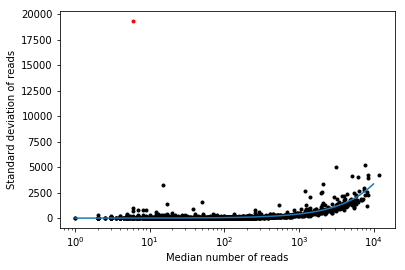

In [444]:
plt.scatter(cov_sum_long["50%"].iloc[expected_long], cov_sum_long["std"].iloc[expected_long], marker=".", c="black")
plt.scatter(cov_sum_long["50%"].iloc[outliers_long], cov_sum_long["std"].iloc[outliers_long], marker=".",  c="red")
plt.plot([pow(10, x) for x in xdata_long], ydata_long)
plt.xscale('log')
plt.xlabel("Median number of reads")
plt.ylabel("Standard deviation of reads")

In [445]:
cov_sum_long.iloc[outliers_long]

,contig_id,count,mean,std,min,25%,50%,75%,max,sample,length
421168,NODE_1135_length_1291_cov_200.006590,1291.0,12380.517428,19355.465461,1.0,3.0,6.0,23984.0,59225.0,CMS002_007a_Rb_S118_L004,1291
